In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from skimage import morphology, measure

In [6]:
images_folder = r'filtrirane_slike_30_izabranih' #-----------------ucitavanje 30 slika---------------
najbolji_roi_preko_90 = r'koeficijenti_korelacije/najbolji_roi_preko_90.xlsx'

In [7]:
def ucitaj_slike(images_folder):
    print("Ucitavanje slika...")
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.png')])
    images = []
    image_names = []
    for img in image_files:
        image_path = os.path.join(images_folder, img)
        img = np.array(Image.open(image_path).convert('L'))
        if img is not None:
            image_names.append(os.path.basename(image_path)) 
        images.append(img)
    print(f"Ucitano {len(images)} slika")
    return images, image_names

In [8]:
images, image_names = ucitaj_slike(images_folder)

Ucitavanje slika...
Ucitano 30 slika


In [9]:
# Funkcija za gamma korekciju
def gamma_korekcija(templates, gamma): # gamma = 2.5
    print("--------Gamma korekcija---------")
    gamma_templates = []
    for template in templates: 
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
        enhanced_img = cv2.LUT(template, table)
        gamma_templates.append(enhanced_img)
    print("----------Gamma korecija zavrsena----------")
    return gamma_templates

In [10]:
def gamma(img):
    gamma = 2.5
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(0, 256)]).astype("uint8")
    enhanced_img = cv2.LUT(img, table)
    return enhanced_img
    
def klasterizacija_roi(roi_box):
    X = roi_box.reshape(-1, 1)
    kmeans = KMeans(n_clusters = 2, n_init = 10, random_state = 0)
    kmeans.fit(X)

    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    sorted_indices = np.argsort(cluster_centers.flatten())
    mask = np.zeros_like(labels)

    mask[labels == sorted_indices[0]] = 0
    mask[labels == sorted_indices[1]] = 1

    #segmented_img = np.array([cluster_map[label] for label in kmeans.labels_])
    segmented_img = mask.reshape(roi_box.shape)

    return segmented_img * 255

In [11]:
def maskiraj_roi_i_sacuvaj(roi_table_path, images, image_names):

    roi_table = pd.read_excel(roi_table_path)
    roi_table['Ime slike'] = roi_table['Ime slike'].str.strip()

    image_dict = dict(zip(image_names, images))

    segmented_imgs = []
    rois = []
    masked_imgs = []
    valid_names = []

    for _, row in roi_table.iterrows():
        img_name = row['Ime slike'].strip()
        if img_name not in image_dict:
            continue

        img = image_dict[img_name]
        x, y, w, h = row[['Koordinata x', 'Koordinata y', 'Širina', 'Visina']].astype(int)

        roi_box = img[y:y+h, x:x+w]
        roi_box_gamma = gamma(roi_box)
        rois.append(roi_box_gamma)

        segmented_img = klasterizacija_roi(roi_box_gamma)
        segmented_imgs.append(segmented_img)

        mask = segmented_img.astype(np.uint8)
        mask_close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
        mask_erode = morphology.binary_erosion(mask_close, morphology.disk(8)).astype('uint8')
        mask_final = cv2.morphologyEx(mask_erode, cv2.MORPH_DILATE, np.ones((7, 7), np.uint8))

        mask_resized = np.zeros_like(img, dtype=np.uint8)
        mask_resized[y:y+h, x:x+w] = mask_final
        masked_img = img.copy()
        masked_img[mask_resized == 1] = 0
        masked_img = masked_img.astype('uint8')

        masked_imgs.append(masked_img)
        valid_names.append(img_name)

    return segmented_imgs, rois, masked_imgs, valid_names

In [12]:
segmented_imgs, rois, masked_imgs1, valid_names = maskiraj_roi_i_sacuvaj(najbolji_roi_preko_90, images, image_names)

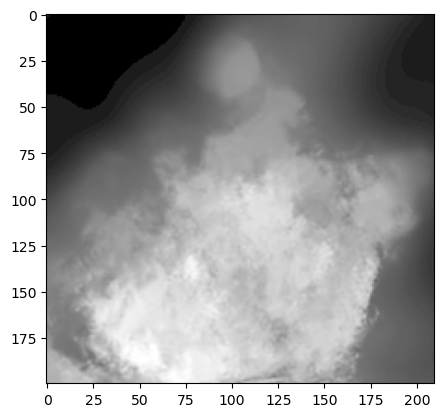

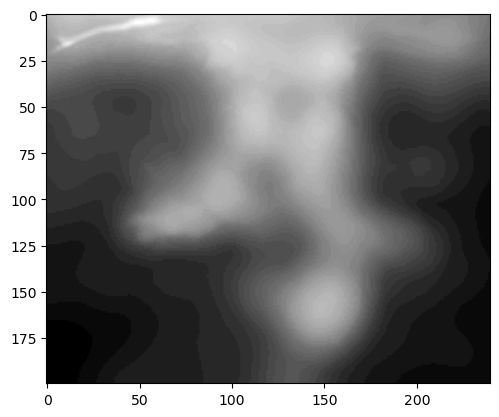

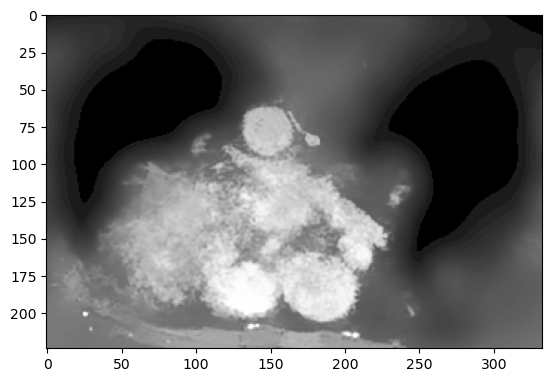

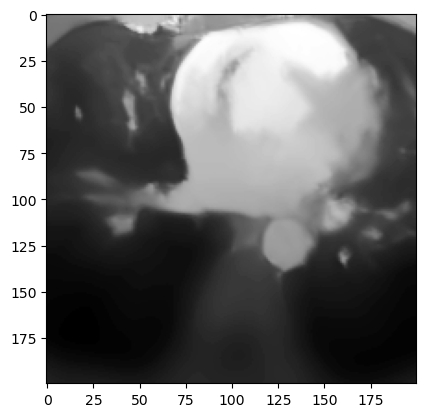

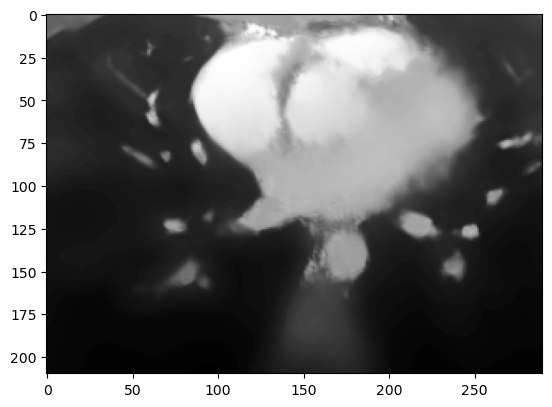

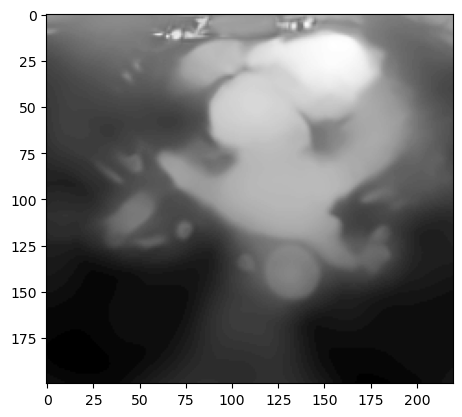

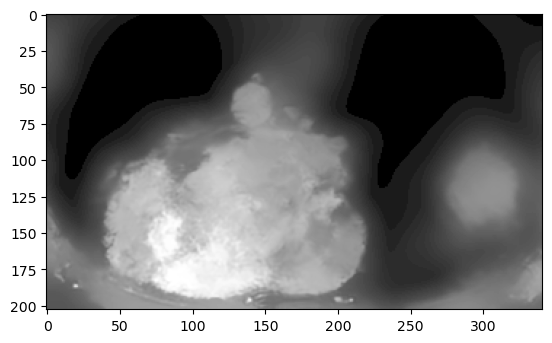

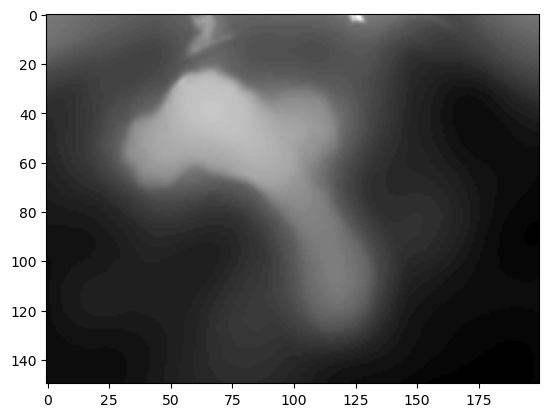

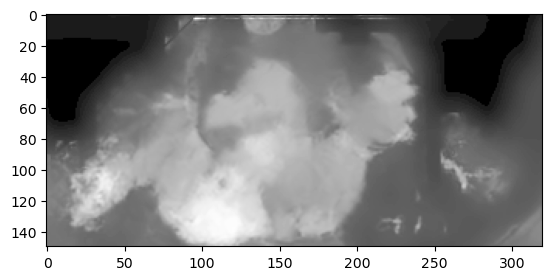

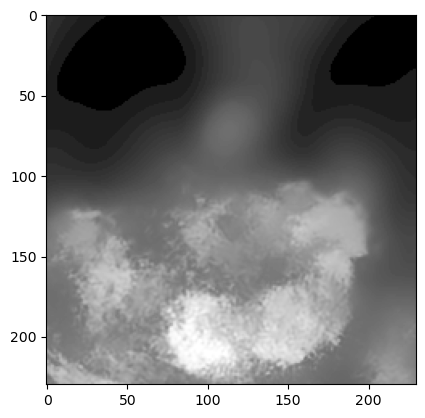

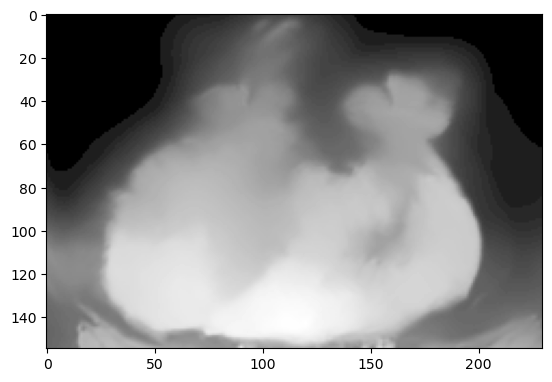

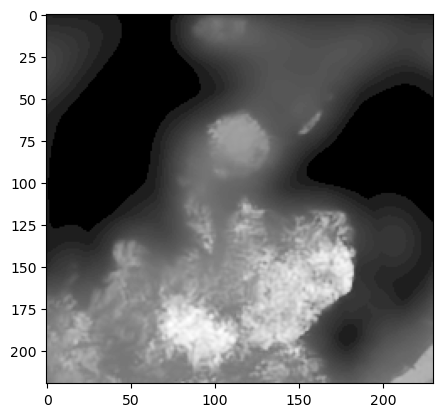

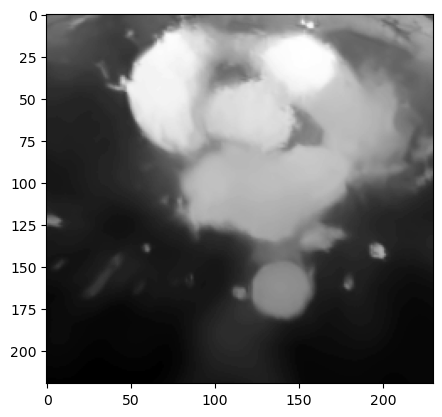

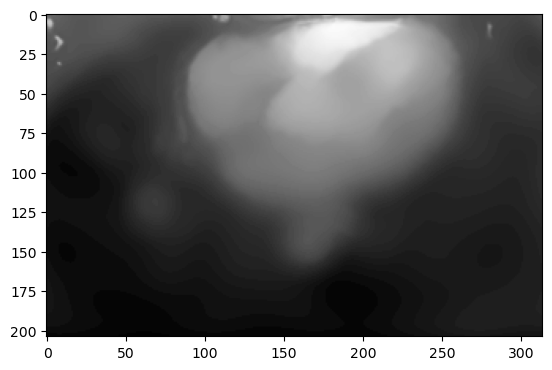

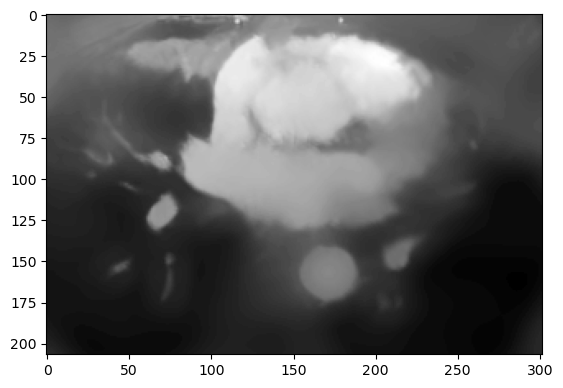

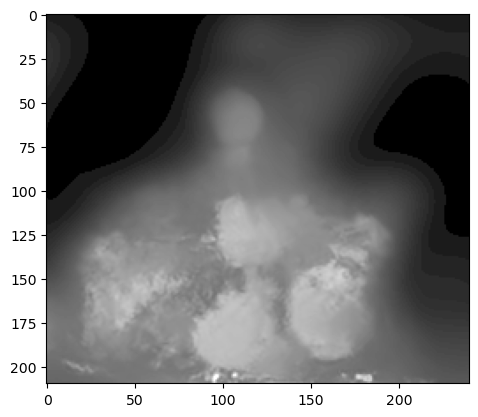

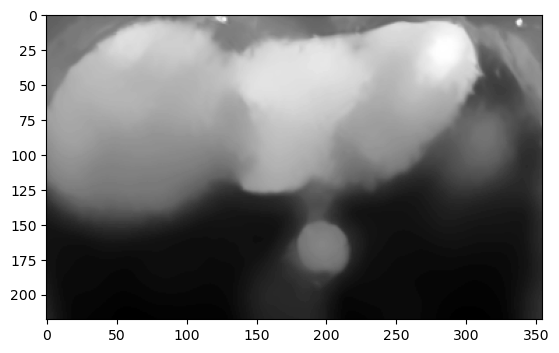

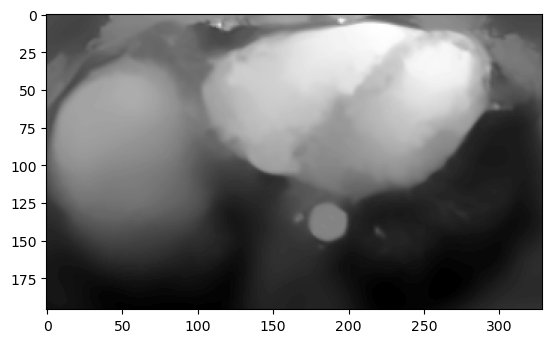

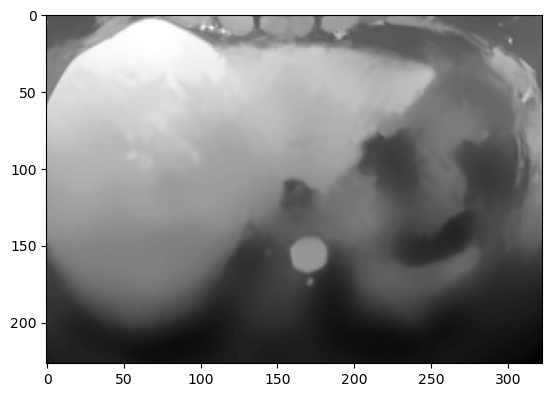

In [13]:
for roi in rois:
    plt.imshow(roi, cmap='gray')
    plt.show()

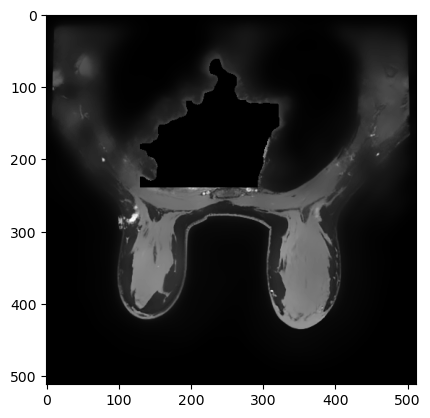

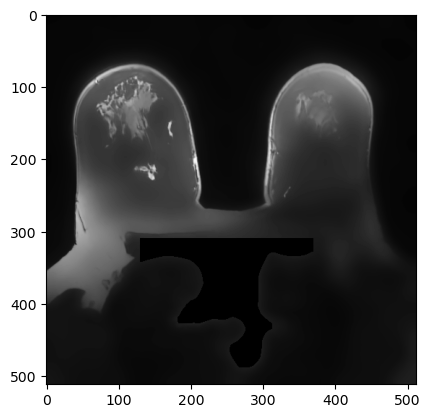

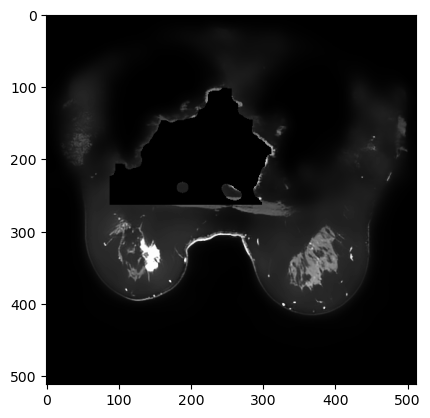

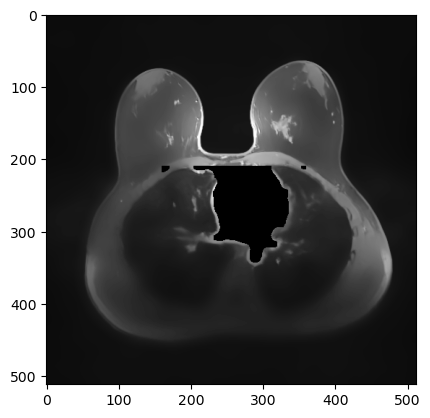

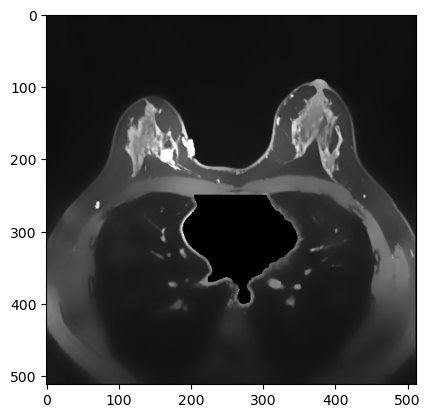

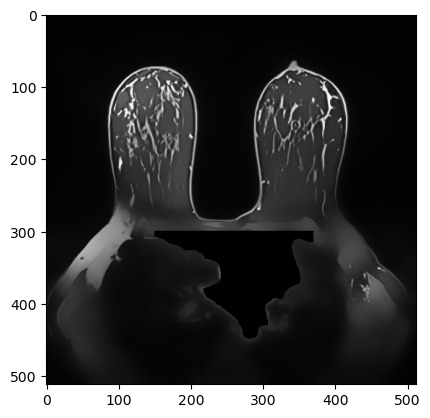

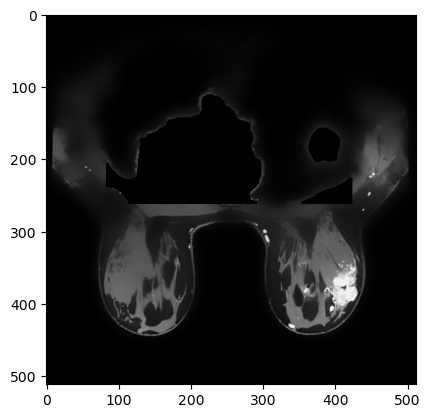

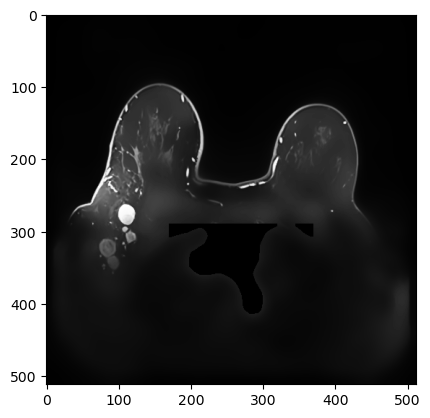

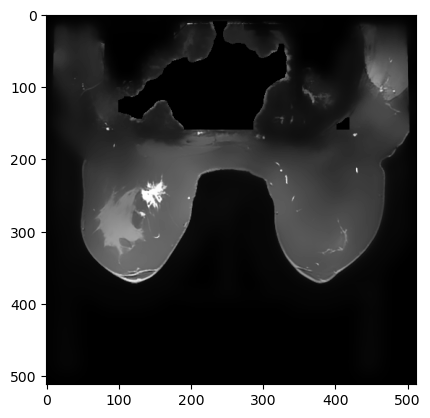

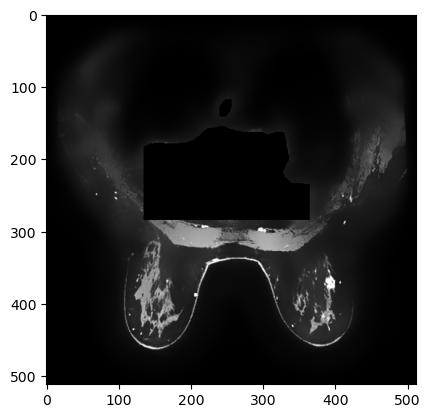

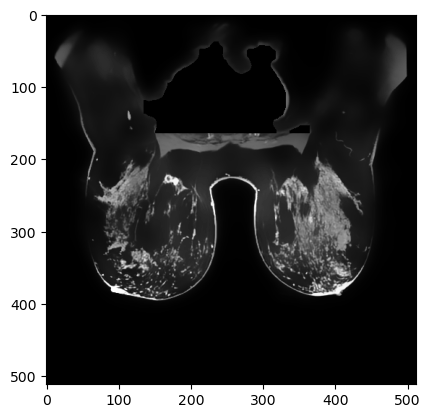

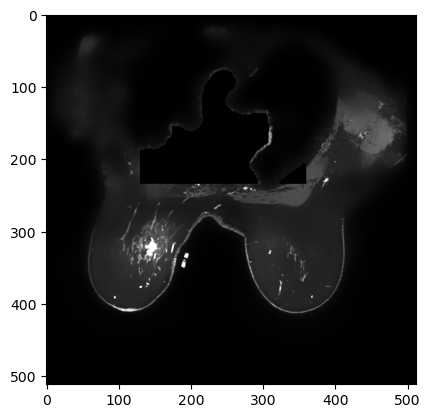

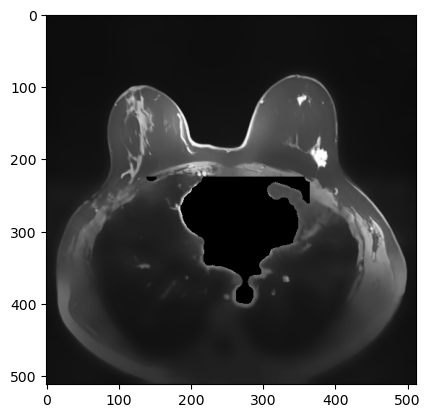

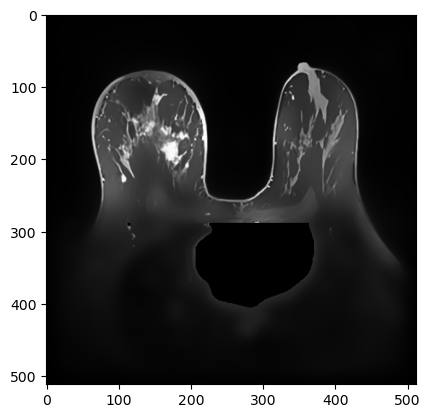

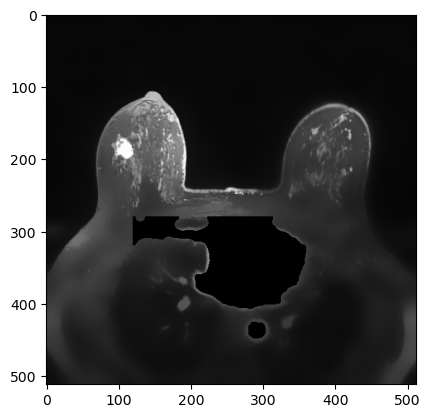

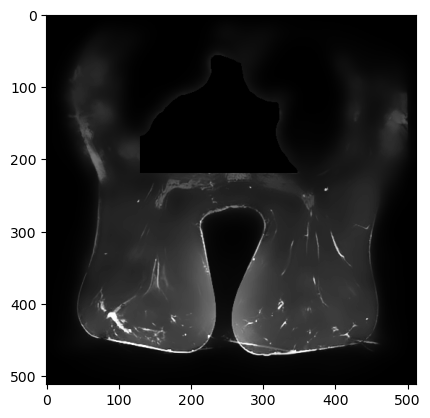

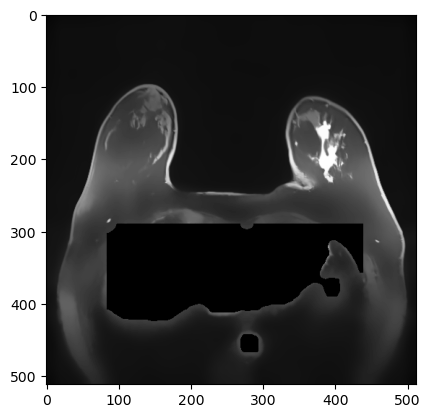

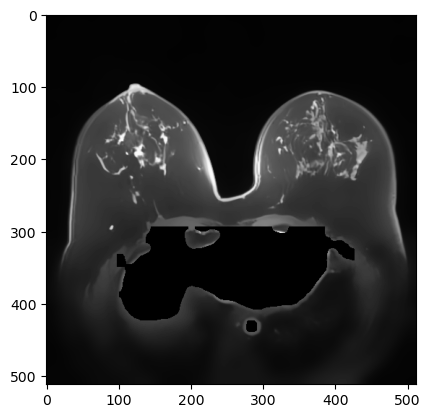

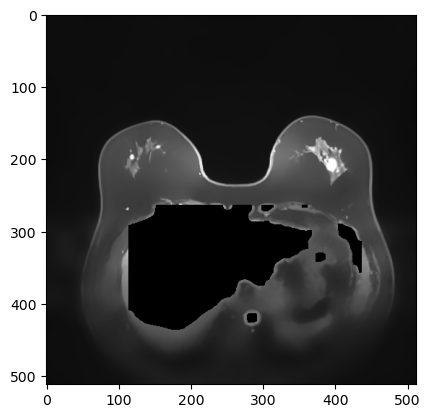

In [14]:
for img in masked_imgs1:
    plt.imshow(img, cmap='gray')
    plt.show()

In [15]:
images_folder_all = r'filtrirane_slike' 
najbolji_roi_preko_90 = r'koeficijenti_korelacije/najbolji_roi_preko_90.xlsx'

In [16]:
images_all, image_names_all = ucitaj_slike(images_folder_all)

Ucitavanje slika...
Ucitano 1614 slika


In [20]:
segmented_imgs, rois, masked_imgs, valid_names = maskiraj_roi_i_sacuvaj(najbolji_roi_preko_90, images_all, image_names_all)

In [25]:
def sacuvaj_maskirane(masked_imgs, valid_names, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for img, name in zip(masked_imgs, valid_names):
        # putanja za čuvanje
        output_path = os.path.join(output_folder, name)
  
        cv2.imwrite(output_path, img)

    print(f"Sacuvano {len(masked_imgs)} maskiranih slika u folder: {output_folder}")

In [26]:
output_folder = r'maskirane_slike'
sacuvaj_maskirane(masked_imgs, valid_names, output_folder)

Sacuvano 1017 maskiranih slika u folder: maskirane_slike


In [27]:
from skimage import measure, morphology

def maske_za_dojke(img_):
    # Normalizacija
    img = cv2.normalize(img_, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # KMeans sa 3 klastera
    X = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
    kmeans.fit(X)

    labels = kmeans.labels_.reshape(img.shape)

    # Nađi klaster koji zauzima najveću površinu 
    cluster_sizes = [np.sum(labels == i) for i in range(3)] 
    selected_cluster = np.argmax(cluster_sizes) # najveći klaster

    # Nađi intenzitete po klasterima
    #cluster_means = [np.mean(img[labels == i]) for i in range(3)]

    # Pretpostavka: dojka = srednji intenzitet (ne najtamniji, ne najsvetliji)
    #sorted_clusters = np.argsort(cluster_means)   # [najtam., srednji, najsvetl.]
    #selected_cluster = sorted_clusters[1]         # biramo srednji

    # Kreiraj masku za taj klaster (dojke = belo)
    mask = (labels == selected_cluster).astype(np.uint8)
    if mask.sum() > 0.8 * mask.size: 
        mask = 1 - mask

    mask_closed = morphology.closing(mask, morphology.disk(15)) 
    mask_final = morphology.erosion(mask_closed, morphology.disk(3)) 
    
    return mask_final


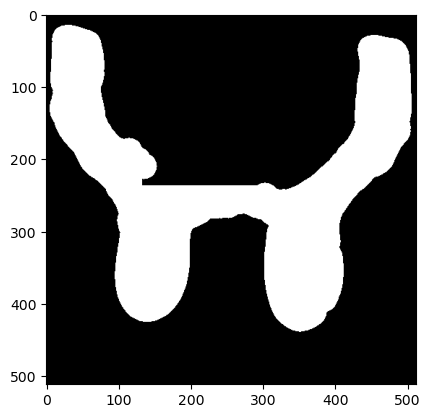

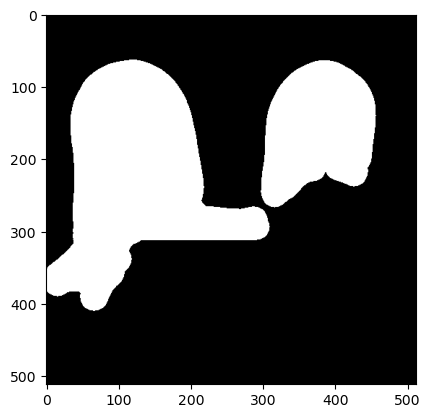

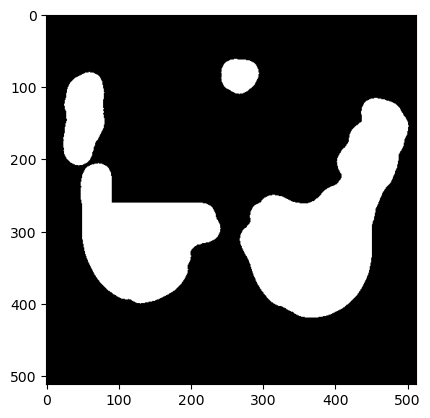

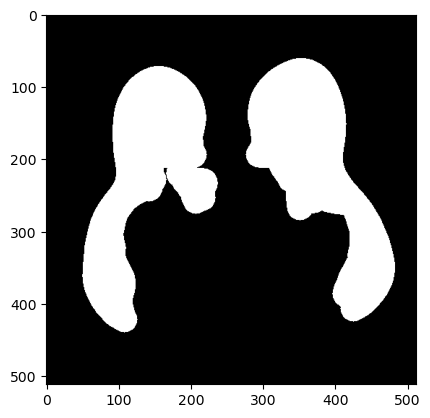

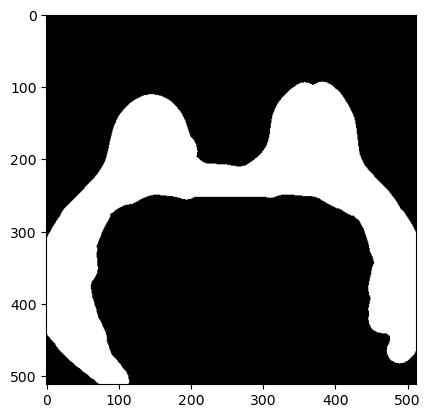

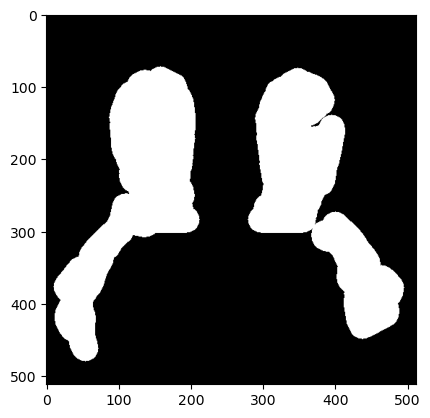

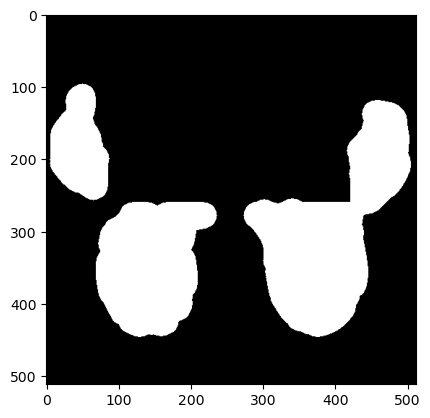

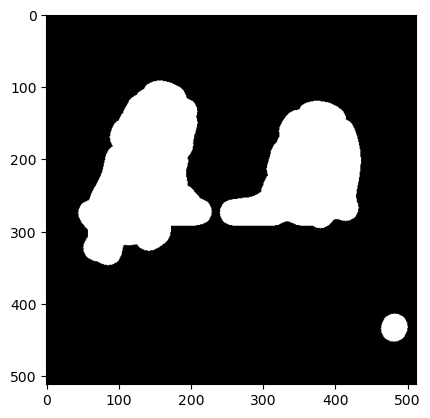

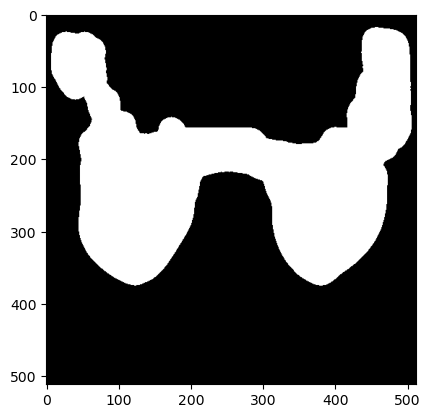

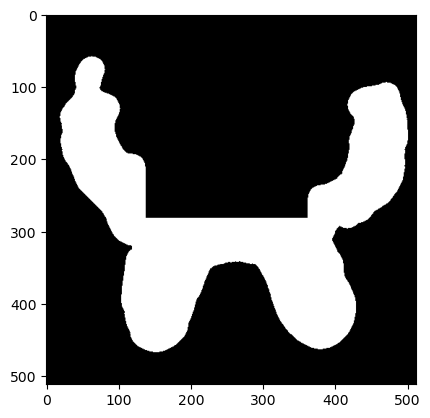

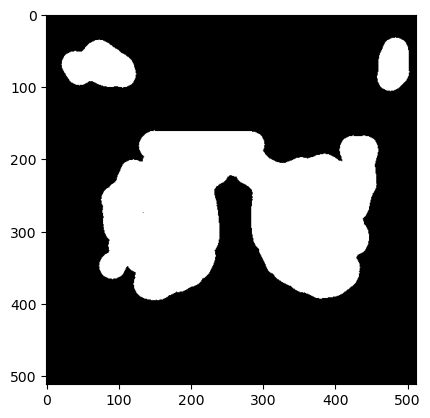

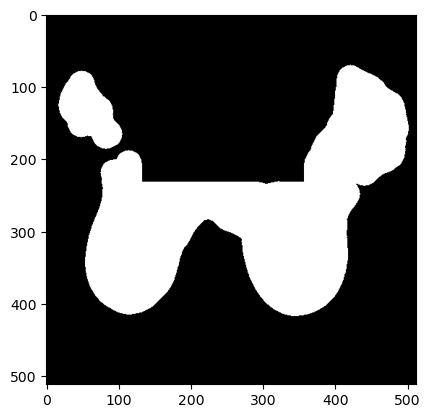

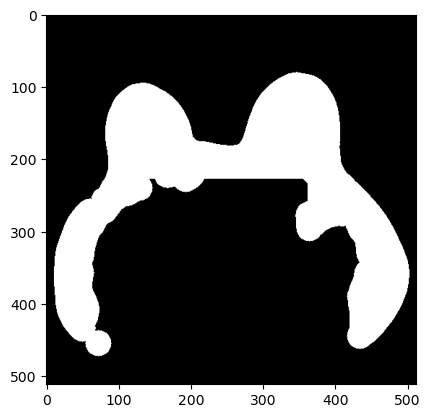

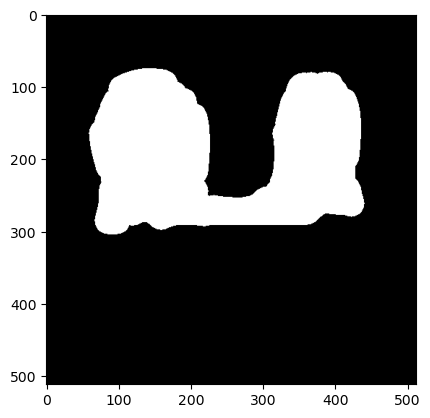

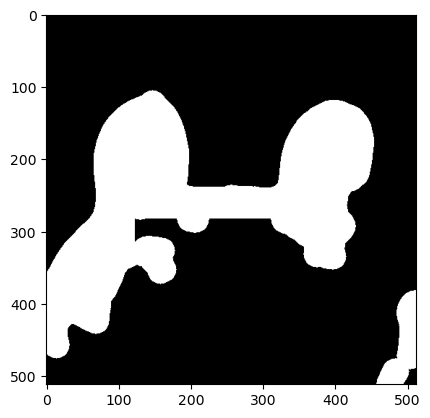

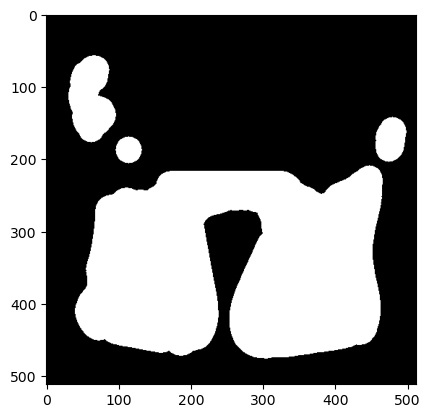

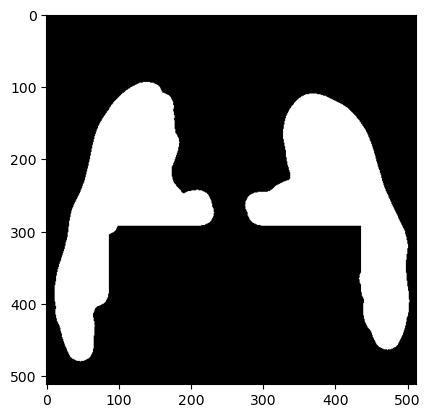

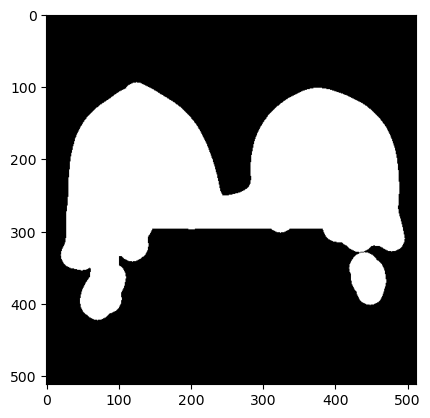

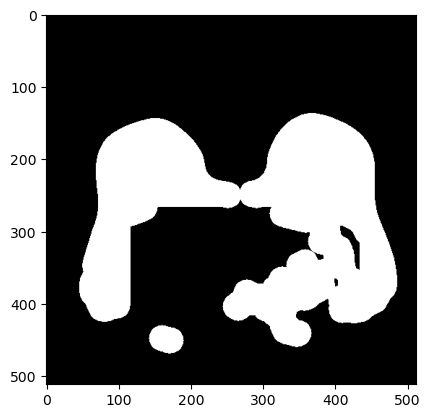

In [28]:
for img in masked_imgs1:
    mask = maske_za_dojke(img)
    plt.imshow(1-mask, cmap='gray')  # invertujemo masku
    plt.show()